In [1]:
# Copyright Elasticsearch B.V. and/or licensed to Elasticsearch B.V. under one
# or more contributor license agreements. Licensed under the Elastic License
# 2.0 and the following additional limitation. Functionality enabled by the
# files subject to the Elastic License 2.0 may only be used in production when
# invoked by an Elasticsearch process with a license key installed that permits
# use of machine learning features. You may not use this file except in
# compliance with the Elastic License 2.0 and the foregoing additional
# limitation.


In [2]:
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import seaborn as sns

from incremental_learning.job import train, update, evaluate
from incremental_learning.trees import Forest
from incremental_learning.storage import download_dataset

# Incremental Learning Illustration

This notebook illustrates how incremental learning improves the prediction of a trained model on previously unseen data.

But first, let's get an intuition behind our approach to incremental learning with decision forests, as shown in the illustration below. 

<img src="02-demo-incremental-learning-updates/incremental-learning-update.gif">

* The initial training produces a model that consists of several prediction trees. Those are magenta, blue, and orange piecewise-linear functions predictions in our example. To evaluate the trained model, we evaluate all trees and aggregate the predictions to produce the final result.
* With new training points for the model update, we identify the best tree to catch the new information without losing the past information ("orange" in our example). 
* Then we re-train the selected tree using old and new data, increasing model fidelity or changing decision boundaries if needed.

Beware that we do not necessarily need to update the latest added tree in the model. We add trees in a specific sequence during the training, usually increasing the model fidelity as we progress. However, once the model is trained, the order of the trees is unimportant. As shown in the animation below, we obtain the same results by stacking predictions in a different order. 

<img src="02-demo-incremental-learning-updates/incremental-learning-interchangable.gif"/>

Now, let's look at how well this works in practice. Although these two-dimensional examples are not simplified, they are well suited for illustration.


## Sine wave classification

In [7]:
dataset_name = 'classification-2d'

download_dataset(dataset_name)
x = np.random.random(5000).reshape((-1, 2))
y = x[:, 1] < (np.sin(x[:, 0]*np.pi/2*4)+1)/2
is_training = (x[:, 0] < 0.3) | (x[:, 0] > 0.7) | (
    x[:, 1] < 0.3) | (x[:, 1] > 0.7)

D = pd.DataFrame(data=x, columns=['x1', 'x2'])
D['target'] = y
D['target'].replace({True: 'true', False: 'false'}, inplace=True)
D['training'] = is_training

D_train = D.where(D['training'] == True).dropna()
D_update = D.where(D['training'] == False).dropna()


[W] incremental_learning >> File /Users/thomasveasey/ml-cpp/jupyter/data/configs/classification-2d.json does not exist.
[W] incremental_learning >> File /Users/thomasveasey/ml-cpp/jupyter/data/datasets/classification-2d.csv does not exist.
[I] incremental_learning >> Downloading configs/classification-2d.json from the Google storage bucket to /Users/thomasveasey/ml-cpp/jupyter/data/configs/classification-2d.json.
[E] incremental_learning >> File datasets/classification-2d.csv does not exist in the Google storage bucket.


Text(0.5, 1.0, 'Update dataset')

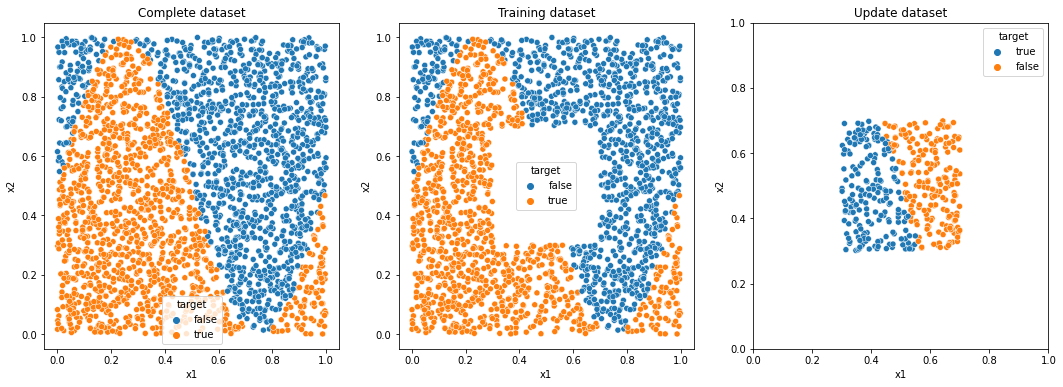

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(18,6))
sns.scatterplot(data=D, x='x1', y='x2', hue='target', ax=axes[0])
axes[0].set_title('Complete dataset')
sns.scatterplot(data=D_train, x='x1', y='x2', hue='target', ax=axes[1])
axes[1].set_title('Training dataset')
sns.scatterplot(data=D_update, x='x1', y='x2', hue='target', ax=axes[2])
axes[2].set_xlim([0,1])
axes[2].set_ylim([0,1])
axes[2].set_title('Update dataset')

In [9]:
job1 = train(dataset_name, D_train[['x1','x2', 'target']], verbose=False)
job1.wait_to_complete()

10.224311828613281

In [10]:
job2 = evaluate(dataset_name=dataset_name, dataset=D[['x1', 'x2', 'target']],
                original_job=job1, verbose=False)
job2.wait_to_complete()

5.210881948471069

In [11]:
job3 = update(dataset_name=dataset_name, dataset=D_update[['x1', 'x2', 'target']],
              original_job=job1, verbose=False)
job3.wait_to_complete()


5.1956470012664795

In [12]:
job4 = evaluate(dataset_name=dataset_name, dataset=D[['x1', 'x2', 'target']],
                original_job=job3, verbose=False)
job4.wait_to_complete()


5.209257125854492

In [13]:
D['predictions'] = job2.get_predictions()
D['updated_predictions'] = job4.get_predictions()

In [14]:
def plot_sinus_values(ax, column, dataset):
    palette = {'true': 'darkorange', 'false': 'seagreen'}
    sns.scatterplot(data=dataset, x='x1', y='x2', hue=column, ax=ax, palette=palette)
    ax.add_patch(patches.Rectangle(xy=(0.3, 0.3), width=0.4, height=0.4, linewidth=2, color='red', fill=False))

def plot_misclassifications(ax, column, dataset):
    sns.scatterplot(data=dataset, x='x1', y='x2', hue=(dataset[column]!=dataset['target']), 
                    ax=ax, palette=['grey', 'red'])
    ax.add_patch(patches.Rectangle(xy=(0.3, 0.3), width=0.4, height=0.4, linewidth=2, color='red', fill=False))

                     

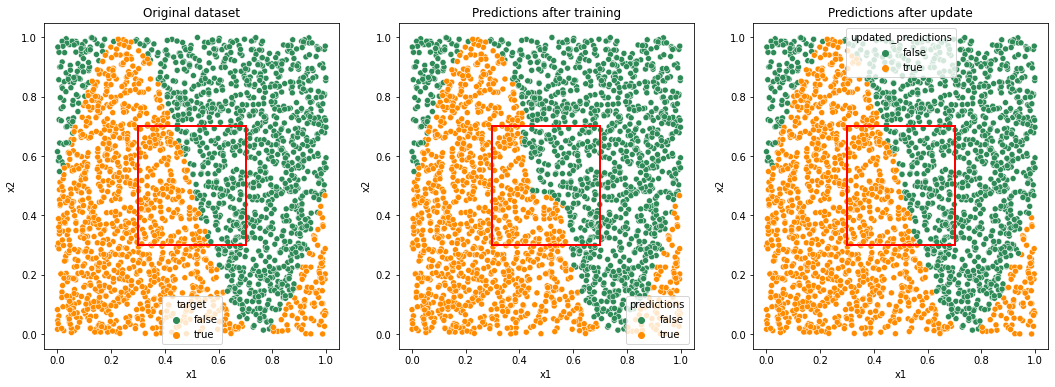

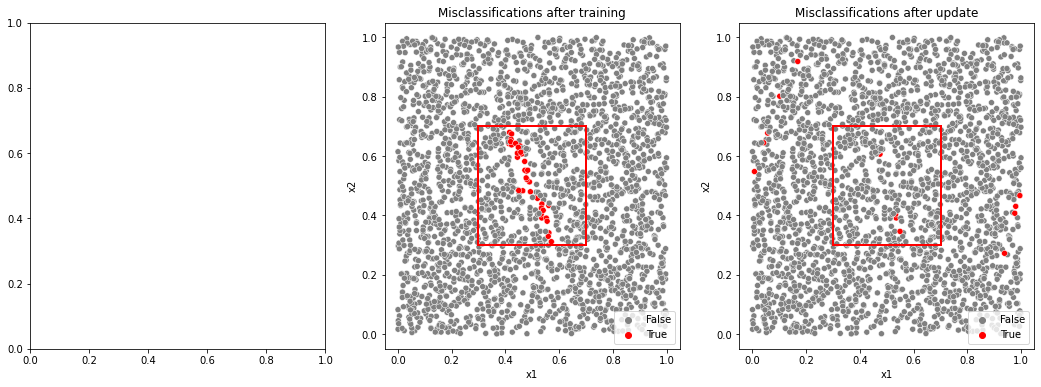

In [15]:
          
fig, axes = plt.subplots(1, 3, figsize=(18,6))
plot_sinus_values(axes[0], 'target', D)
axes[0].set_title('Original dataset')
plot_sinus_values(axes[1], 'predictions', D)
axes[1].set_title('Predictions after training')
plot_sinus_values(axes[2], 'updated_predictions', D)
axes[2].set_title('Predictions after update')

fig, axes = plt.subplots(1, 3, figsize=(18,6))
plot_misclassifications(axes[1], 'predictions', D)
axes[1].set_title('Misclassifications after training')
plot_misclassifications(axes[2], 'updated_predictions', D)
axes[2].set_title('Misclassifications after update')
plt.show()

## Circles classification

In [16]:
dataset_name = 'classification-2d'

download_dataset(dataset_name)
x = np.random.random(5000).reshape((-1, 2))
y = ((x[:, 1]-0.5)**2+(x[:, 0]-0.5)**2 < 0.5 **
     2) & ((x[:, 1]-0.5)**2+(x[:, 0]-0.5)**2 > 0.3**2)
is_training = (x[:, 0]//0.25 + x[:, 1]//0.25) % 2 == 1

D = pd.DataFrame(data=x, columns=['x1', 'x2'])
D['target'] = y
D['target'].replace({True: 'true', False: 'false'}, inplace=True)
D['training'] = is_training

D_train = D.where(D['training'] == True).dropna()
D_update = D.where(D['training'] == False).dropna()


[W] incremental_learning >> File /Users/thomasveasey/ml-cpp/jupyter/data/datasets/classification-2d.csv does not exist.
[I] incremental_learning >> Downloading configs/classification-2d.json from the Google storage bucket to /Users/thomasveasey/ml-cpp/jupyter/data/configs/classification-2d.json.
[E] incremental_learning >> File datasets/classification-2d.csv does not exist in the Google storage bucket.


Text(0.5, 1.0, 'Update dataset')

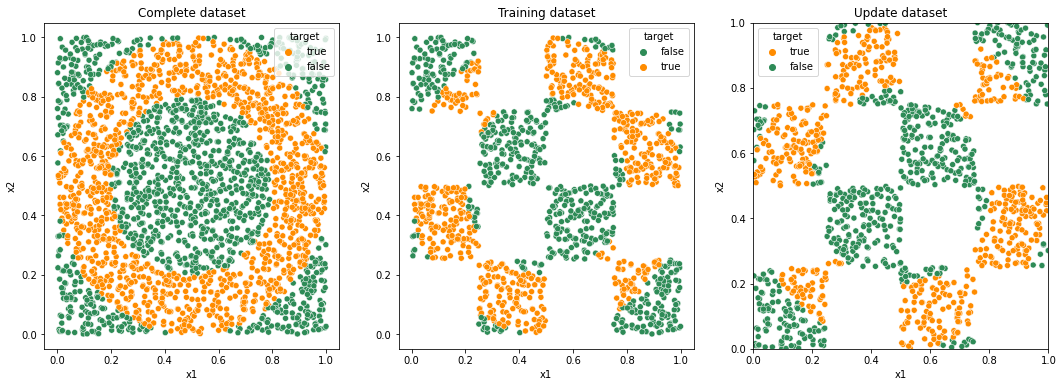

In [17]:
palette = {'true': 'darkorange', 'false': 'seagreen'}
fig, axes = plt.subplots(1, 3, figsize=(18,6))
sns.scatterplot(data=D, x='x1', y='x2', hue='target', ax=axes[0], palette=palette)
axes[0].set_title('Complete dataset')
sns.scatterplot(data=D_train, x='x1', y='x2', hue='target', ax=axes[1], palette=palette)
axes[1].set_title('Training dataset')
sns.scatterplot(data=D_update, x='x1', y='x2', hue='target', ax=axes[2], palette=palette)
axes[2].set_xlim([0,1])
axes[2].set_ylim([0,1])
axes[2].set_title('Update dataset')

In [18]:
job1 = train(dataset_name, D_train[['x1','x2', 'target']], verbose=False)
job1.wait_to_complete()

15.265475273132324

In [19]:
job2 = evaluate(dataset_name=dataset_name, dataset=D[['x1','x2', 'target']], original_job=job1, verbose=False)
job2.wait_to_complete()

5.225375175476074

In [20]:
job3 = update(dataset_name=dataset_name, dataset=D_update[['x1','x2', 'target']], original_job=job1, verbose=False)
job3.wait_to_complete()

5.223259925842285

In [21]:
job4 = evaluate(dataset_name=dataset_name, dataset=D[['x1','x2', 'target']], original_job=job3, verbose=False)
job4.wait_to_complete()

5.208544015884399

In [22]:
D['predictions'] = job2.get_predictions()
D['updated_predictions'] = job4.get_predictions()

In [23]:
def plot_checkerboard(ax, column, dataset):
    palette = {'true': 'darkorange', 'false': 'seagreen'}
    sns.scatterplot(data=dataset, x='x1', y='x2', hue=column, ax=ax, palette=palette)
    for i in range(4):
        for j in range(4):
            if (i+j) % 2 == 0:
                ax.add_patch(patches.Rectangle(xy=(0.25*i, 0.25*j), width=0.25, height=0.25,
                                               linewidth=0, color='grey', fill=True, alpha=0.4, zorder=-1))


def plot_misclassifications(ax, column, dataset):
    sns.scatterplot(data=dataset, x='x1', y='x2', hue=(dataset[column] != dataset['target']),
                    ax=ax, palette=['grey', 'red'])
    for i in range(4):
        for j in range(4):
            if (i+j) % 2 == 0:
                ax.add_patch(patches.Rectangle(xy=(0.25*i, 0.25*j), width=0.25, height=0.25,
                                               linewidth=0, color='grey', fill=True, alpha=0.4, zorder=-1))


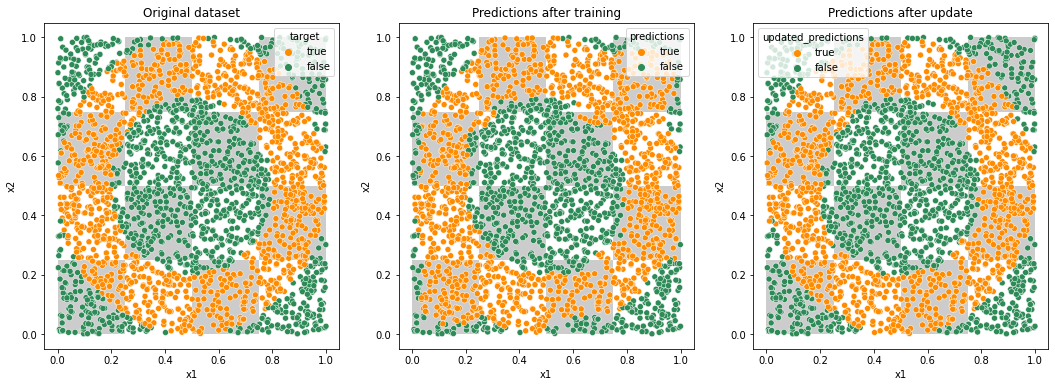

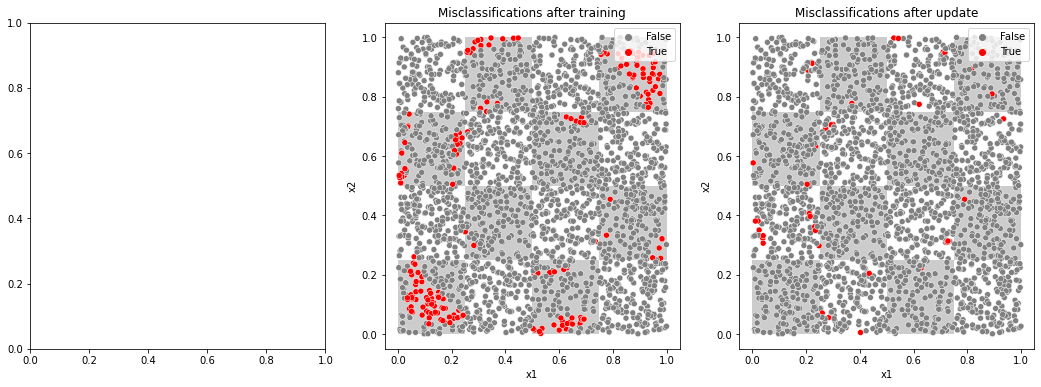

In [24]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
plot_checkerboard(axes[0], 'target', D)
axes[0].set_title('Original dataset')
plot_checkerboard(axes[1], 'predictions', D)
axes[1].set_title('Predictions after training')
plot_checkerboard(axes[2], 'updated_predictions', D)
axes[2].set_title('Predictions after update')

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
plot_misclassifications(axes[1], 'predictions', D)
axes[1].set_title('Misclassifications after training')
plot_misclassifications(axes[2], 'updated_predictions', D)
axes[2].set_title('Misclassifications after update')
plt.show()


### Circles regression


In [37]:
dataset_name = 'regression-2d'

download_dataset(dataset_name)
size = 5000
low = -np.pi
high = np.pi
x = np.random.uniform(low, high, 2*size).reshape(size, -1)
y = np.sin((x[:, 0])**2+x[:, 1]**2)
x = (x-low)/(high-low)

is_training = (x[:, 0]//0.25 + x[:, 1]//0.25) % 2 == 1

D = pd.DataFrame(data=x, columns=['x1', 'x2'])
D['target'] = y
D['target'].replace({True: 'true', False: 'false'}, inplace=True)
D['training'] = is_training

D_train = D.where(D['training'] == True).dropna()
D_update = D.where(D['training'] == False).dropna()


[W] incremental_learning >> File /Users/thomasveasey/ml-cpp/jupyter/data/datasets/regression-2d.csv does not exist.
[I] incremental_learning >> Downloading configs/regression-2d.json from the Google storage bucket to /Users/thomasveasey/ml-cpp/jupyter/data/configs/regression-2d.json.
[E] incremental_learning >> File datasets/regression-2d.csv does not exist in the Google storage bucket.


Text(0.5, 1.0, 'Update dataset')

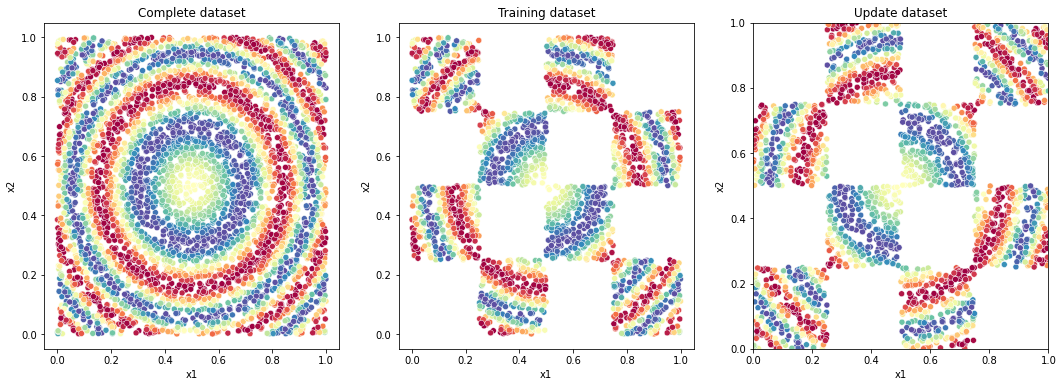

In [38]:
fig, axes = plt.subplots(1, 3, figsize=(18,6))
# fig.suptitle('1 row x 2 columns axes with no data')
sns.scatterplot(data=D, x='x1', y='x2', hue='target', ax=axes[0], palette='Spectral', 
                    hue_norm=(-1.0, 1.0), legend=False)
axes[0].set_title('Complete dataset')
sns.scatterplot(data=D_train, x='x1', y='x2', hue='target', ax=axes[1], palette='Spectral', 
                    hue_norm=(-1.0, 1.0), legend=False)
axes[1].set_title('Training dataset')
sns.scatterplot(data=D_update, x='x1', y='x2', hue='target', ax=axes[2], palette='Spectral', 
                    hue_norm=(-1.0, 1.0), legend=False)
axes[2].set_xlim([0,1])
axes[2].set_ylim([0,1])
axes[2].set_title('Update dataset')

In [39]:
job1 = train(dataset_name, D_train[['x1', 'x2', 'target']],
             verbose=False)
job1.wait_to_complete()


10.252205848693848

In [40]:
job2 = evaluate(dataset_name=dataset_name, dataset=D[['x1', 'x2', 'target']],
                original_job=job1, verbose=False)
job2.wait_to_complete()


5.207970142364502

In [41]:
job3 = update(dataset_name=dataset_name, dataset=D_update[['x1','x2', 'target']], original_job=job1, verbose=False)
job3.wait_to_complete()

5.220748662948608

In [42]:
job4 = evaluate(dataset_name=dataset_name, dataset=D[['x1', 'x2', 'target']],
                original_job=job3, verbose=False)
job4.wait_to_complete()


5.210984230041504

In [43]:
D['predictions'] = job2.get_predictions()
D['updated_predictions'] = job4.get_predictions()


In [35]:
def plot_checkerboard(ax, column, dataset):
    sns.scatterplot(data=dataset, x='x1', y='x2', hue=column, ax=ax, palette='Spectral', 
                    hue_norm=(-1.0, 1.0), legend=False)
    for i in range(4):
        for j in range(4):
            if (i+j)%2 ==0:
                ax.add_patch(patches.Rectangle(xy=(0.25*i, 0.25*j), width=0.25, height=0.25, 
                                   linewidth=0, color='grey', fill=True, alpha=0.4, zorder=5))
                
def plot_error(ax, column, dataset):
    sns.scatterplot(data=dataset, x='x1', y='x2', hue=np.abs(dataset[column]-dataset['target']), 
                    ax=ax, palette="YlOrBr", hue_norm=(0, 2.0), legend=False)
    for i in range(4):
        for j in range(4):
            if (i+j)%2 ==0:
                ax.add_patch(patches.Rectangle(xy=(0.25*i, 0.25*j), width=0.25, height=0.25, 
                                   linewidth=0, color='grey', fill=True, alpha=0.4, zorder=5))

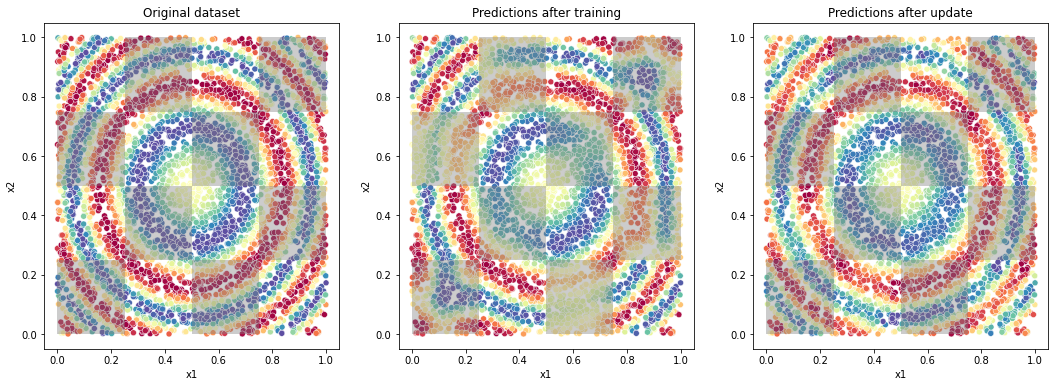

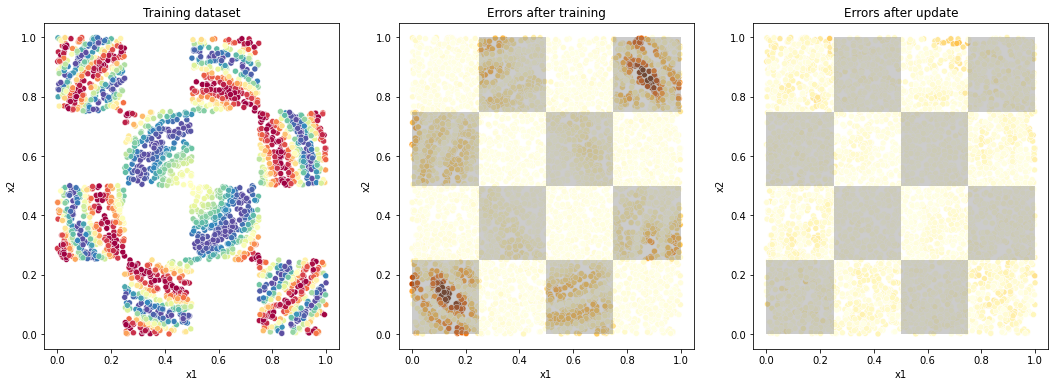

In [36]:

fig, axes = plt.subplots(1, 3, figsize=(18,6))
plot_checkerboard(axes[0], 'target', D)
axes[0].set_title('Original dataset')
plot_checkerboard(axes[1], 'predictions', D)
axes[1].set_title('Predictions after training')
plot_checkerboard(axes[2], 'updated_predictions', D)
axes[2].set_title('Predictions after update')

fig, axes = plt.subplots(1, 3, figsize=(18,6))
sns.scatterplot(data=D_train, x='x1', y='x2', hue='target', ax=axes[0], palette='Spectral', 
                    hue_norm=(-1.0, 1.0), legend=False)
axes[0].set_title('Training dataset')
plot_error(axes[1], 'predictions', D)
axes[1].set_title('Errors after training')
plot_error(axes[2], 'updated_predictions', D)
axes[2].set_title('Errors after update')
plt.show()